<a href="https://colab.research.google.com/github/LiyaGaynutdinova/mlp_MNIST/blob/main/MLP_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Týden 13. Konvoluční sítě a autoenkodéry.
Dneska ukážeme jak vytvářet konvoluční neuronové sítě a v PyTorch. Sestavíme konvoluční neuronovou síť, která plní stejný úkol klasifikace ručně psaných číslic z minulého cvičení.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cuda device


Nyní můžeme stavět konvoluční síť, která se bude skládat z konvoluční a z plně propojené části. Ukažeme, lze tuto síť sestavit elegantně pomocí kontejneru `Sequential`.

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same'),  #28x28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'), #14x14
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x_conv = self.conv(x)
        x_out = self.linear(x_conv)
        return x_out

net = ConvNet().to(device)
print(net)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=10, bias=True)
    (2): Softmax(dim=1)
  )
)


Nahrajeme dataset:

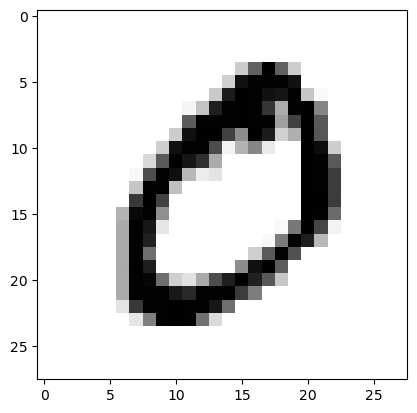

In [2]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

plt.imshow(train_dataset.__getitem__(1)[0].squeeze(), cmap='gray_r')

Účelová funkce zůstává stejná:

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

Ukažeme, jak můžeme ukládat natrenováné sítě pro další použití:

In [133]:
def save_network(net:nn.Module, filename):
    torch.save({'model_state_dict': net.state_dict()}, filename)

def load_network(net, filename, dev):
    state = torch.load(open(filename, "rb") , map_location=dev)
    net.load_state_dict(state['model_state_dict'])
    return net

Při trénování musíme po každé epoše zkontrolovat chybu v testovací množině dat, abychom se ujistili, že model dobře zobecňuje.

In [ ]:
epochs = 10

train_losses = []
test_losses = []

for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Training Loss: {running_loss / 100:.3f}, Training Accuracy: {100 * correct / total:.2f}%")
            save_network(net, f'ConvNet_{epoch}')
            train_losses.append(running_loss / 100)
            running_loss = 0.0
            correct = 0
            total = 0

    net.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch + 1}, Test Loss: {test_loss:.3f}, Test Accuracy: {100 * correct / total:.2f}%")

Nyní můžeme vykreslit průběh tréninku.

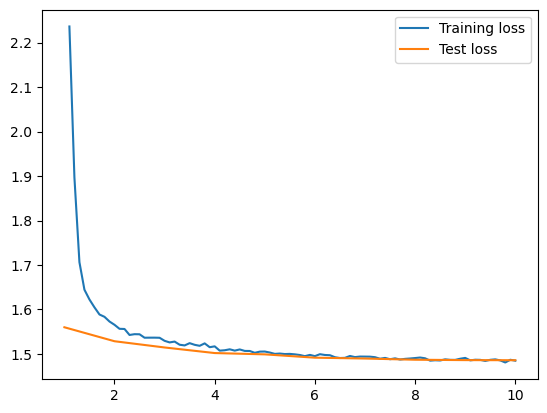

In [36]:
plt.plot(np.arange(1.1, 10.1, 0.1), train_losses, label='Training loss')
plt.plot(np.arange(1., 11.), test_losses, label='Test loss')
plt.legend()
plt.show()

Konvoluční sítě dosahují lepších výsledků v této úloze, než plně propojené sítě proto, že jsou translačně invariantní, což znamená, že má schopnost rozpoznat vzory bez ohledu na jejich polohu v obrázku. Podíváme se, jak probíha komprese dat v modelu v pomocí konvolučních vrstev a poolingu: 

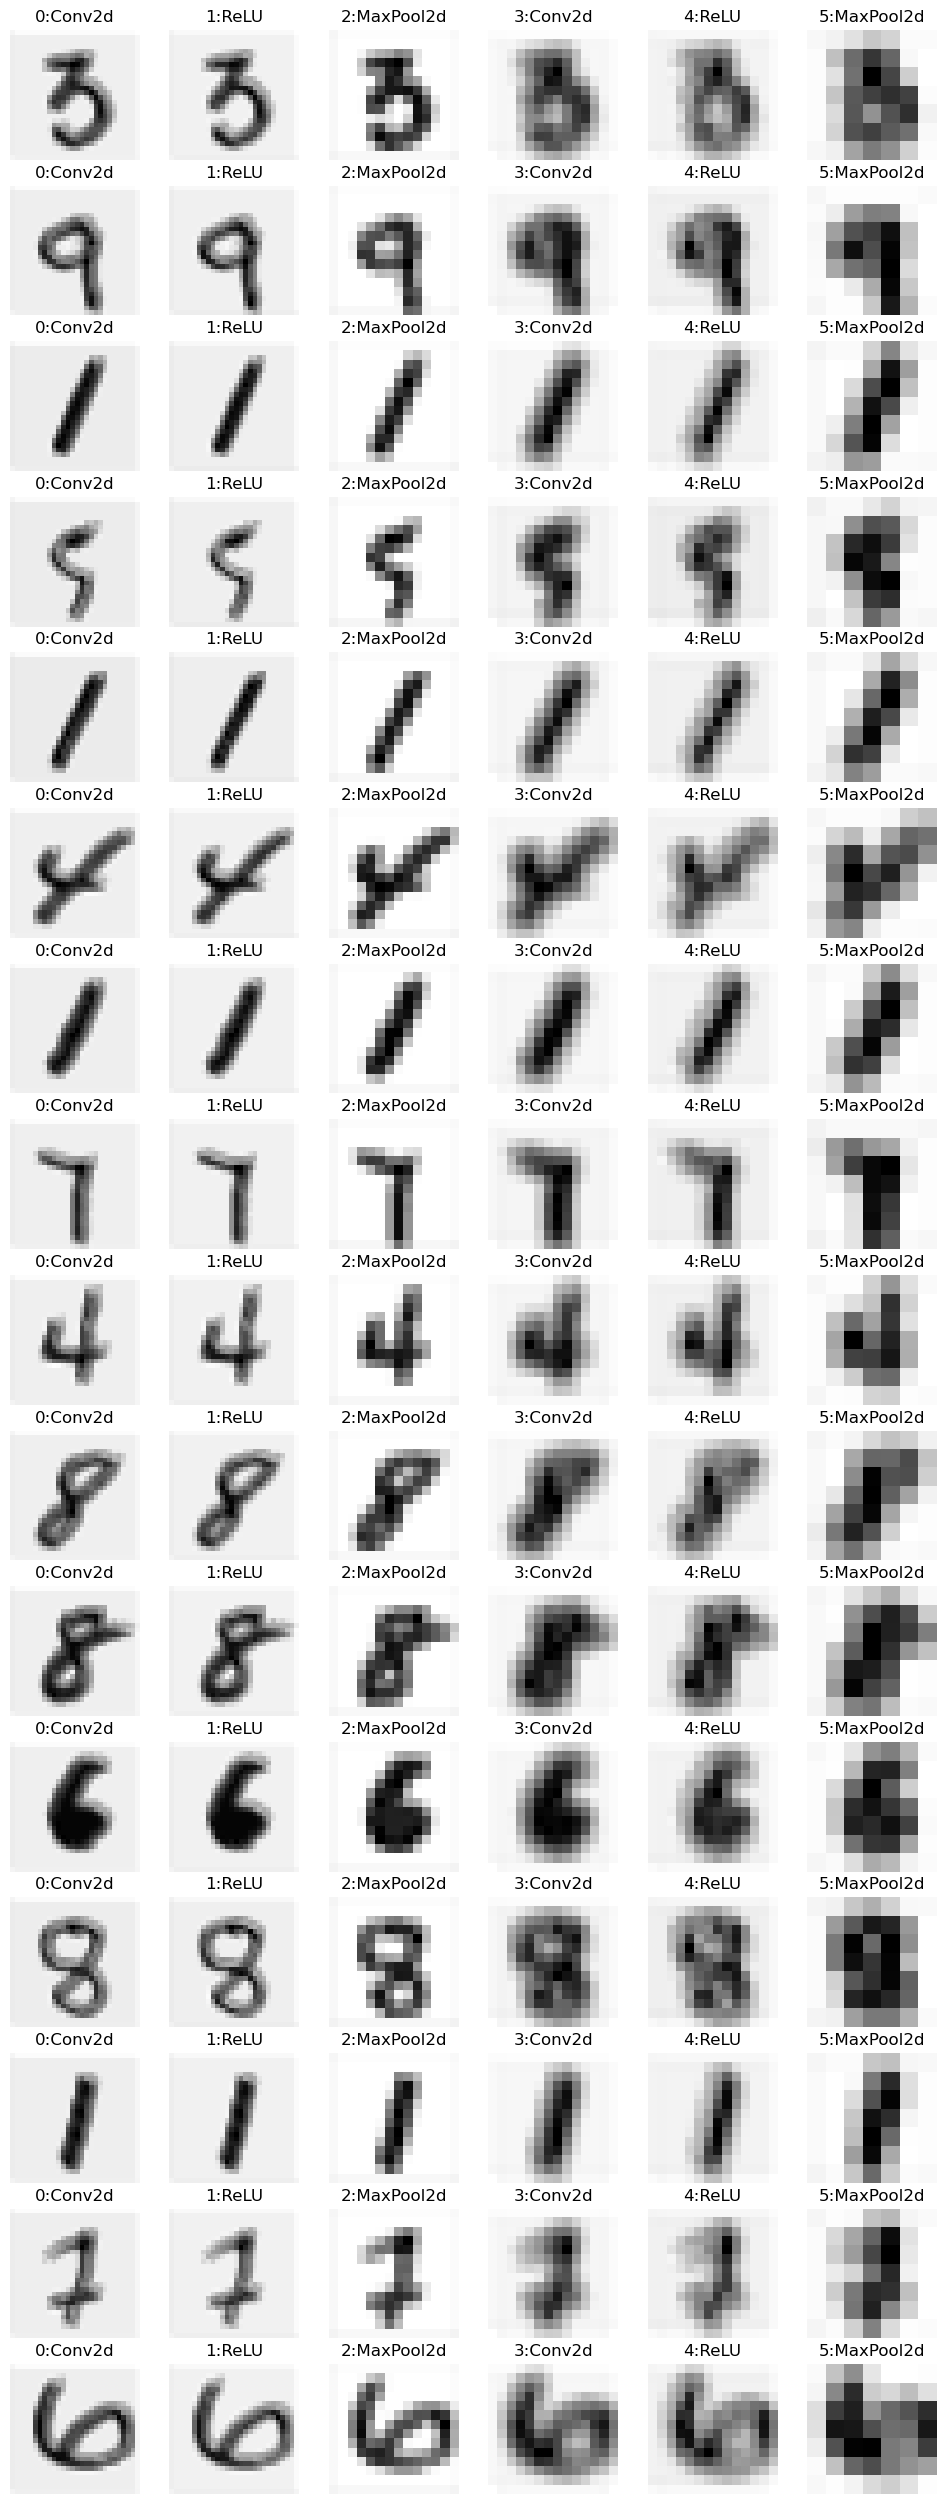

In [77]:
train_iterator = iter(train_loader)
inputs, labels = next(train_iterator)
inputs, labels = inputs.to(device), labels.to(device)
fig, axs = plt.subplots(nrows=16, ncols=6, figsize=(12, 32))

for (i, l) in enumerate(net.conv):
    inputs = l.forward(inputs)
    f = (inputs.detach()**2).sum(dim=1).sqrt()
    for j in range(16):
        axs[j, i].imshow(f[j].cpu().numpy(), cmap='gray_r')
        axs[j, i].set_axis_off()
        axs[j, i].set_title("{}:{}".format(i, l.__class__.__name__))

Tyto nelineární komprese využivájí autoenkodéry k generování nových dat. Pojďme to ukázat:

In [163]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  

        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten()
        )

        self.encoder_mu = nn.Linear(64*7*7, latent_dims)
        self.encoder_sigma = nn.Linear(64*7*7, latent_dims)

        self.decoder_linear = nn.Sequential(
            nn.Linear(latent_dims, 64*7*7),
            nn.ReLU(),   
        )

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),
            nn.Sigmoid()
        )

        self.N = torch.distributions.Normal(0, 1)
        if device == torch.device('cuda'):
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.encoder(x)
        mu =  self.encoder_mu(x)
        sigma =  torch.exp(self.encoder_sigma(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1/2).sum()
        x_rec = self.decoder_linear(z)
        x_rec = self.decoder_conv(x_rec.view(-1,64,7,7))
        return x_rec, z
    
VAE = VariationalEncoder(64).to(device)
print(VAE)

VariationalEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (encoder_mu): Linear(in_features=3136, out_features=64, bias=True)
  (encoder_sigma): Linear(in_features=3136, out_features=64, bias=True)
  (decoder_linear): Sequential(
    (0): Linear(in_features=64, out_features=3136, bias=True)
    (1): ReLU()
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)


Použijeme jinou ztrátovou funkci. Navíc se bude hodit automatická redukce míry učení pomoci objektu `Scheduler`.

In [164]:
criterion = nn.MSELoss(reduction='none')
optimizer = optim.Adam(VAE.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

In [165]:
epochs = 50

train_losses = []
test_losses = []

for epoch in range(epochs):
    VAE.train()
    running_loss = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, _ = data
        inputs = inputs.to(device)

        optimizer.zero_grad()

        outputs, _ = VAE(inputs)
        loss = criterion(outputs, inputs).sum() + VAE.kl
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Training Loss: {running_loss / 100:.3f}")
            save_network(VAE, f'VAE_{epoch}')
            train_losses.append(running_loss / 100)
            running_loss = 0.0

    VAE.eval()
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, _ = data
            inputs = inputs.to(device)

            outputs, _ = VAE(inputs)
            loss = criterion(outputs, inputs).sum() + VAE.kl
            test_loss += loss.item()

        test_loss /= len(test_loader)
        scheduler.step(test_loss)
        test_losses.append(test_loss)
        print(f"Epoch: {epoch + 1}, Test Loss: {test_loss:.3f}")

Epoch: 1, Batch: 100, Training Loss: 61301.299
Epoch: 1, Batch: 200, Training Loss: 51658.718
Epoch: 1, Batch: 300, Training Loss: 47393.450
Epoch: 1, Batch: 400, Training Loss: 45836.416
Epoch: 1, Batch: 500, Training Loss: 44836.809
Epoch: 1, Batch: 600, Training Loss: 43301.738
Epoch: 1, Batch: 700, Training Loss: 41899.656
Epoch: 1, Batch: 800, Training Loss: 39969.489
Epoch: 1, Batch: 900, Training Loss: 38028.059
Epoch: 1, Test Loss: 36975.047
Epoch: 2, Batch: 100, Training Loss: 36354.160
Epoch: 2, Batch: 200, Training Loss: 35469.252
Epoch: 2, Batch: 300, Training Loss: 34904.571
Epoch: 2, Batch: 400, Training Loss: 34228.151
Epoch: 2, Batch: 500, Training Loss: 33948.051
Epoch: 2, Batch: 600, Training Loss: 33683.662
Epoch: 2, Batch: 700, Training Loss: 33304.891
Epoch: 2, Batch: 800, Training Loss: 33097.298
Epoch: 2, Batch: 900, Training Loss: 32784.801
Epoch: 2, Test Loss: 32658.129
Epoch: 3, Batch: 100, Training Loss: 32557.085
Epoch: 3, Batch: 200, Training Loss: 32154.15

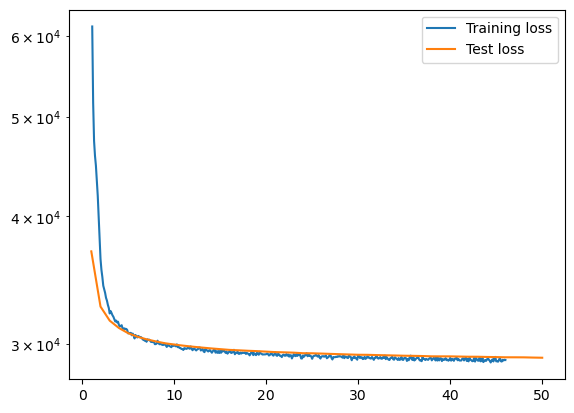

In [174]:
plt.plot(np.arange(1.1, 46.1, 0.1), train_losses, label='Training loss')
plt.plot(np.arange(1., 51.), test_losses, label='Test loss')
plt.yscale('log')
plt.legend()
plt.show()

Protože trenink této sítě může trvát déle, pro účely cvičení stačí použit předtrenovánou síť:

In [167]:
VAE = load_network(VAE, 'VAE_49', device)

Podiváme se, jak dobře náš autoenkodér schopen rekonstruovat obrázky:

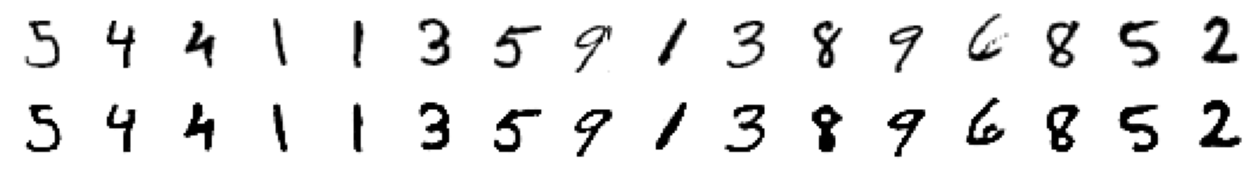

In [169]:
train_iterator = iter(train_loader)
inputs, _ = next(train_iterator)
inputs = inputs.to(device)

outputs, _ = VAE(inputs)

fig, axs = plt.subplots(ncols=16, nrows=2, figsize=(16, 2))
for i in range(16):
    axs[0, i].imshow(inputs[i, 0].cpu().detach(), cmap='gray_r')
    axs[1, i].imshow(outputs[i, 0].cpu().detach(), cmap='gray_r')
    axs[0, i].set_axis_off()
    axs[1, i].set_axis_off()

Zkusme vygenerovat úplně nová data:

In [175]:
mu_list = []
sigma_list = []

with torch.no_grad():
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        encoded_data = VAE.encoder(inputs)
        mu = VAE.encoder_mu(encoded_data)
        sigma = torch.exp(VAE.encoder_sigma(encoded_data))
        mu_list.append(mu.cpu().numpy())
        sigma_list.append(sigma.cpu().numpy())

# Average mu and sigma (or just use them directly)
avg_mu = np.mean(np.concatenate(mu_list, axis=0), axis=0)
avg_sigma = np.mean(np.concatenate(sigma_list, axis=0), axis=0)

# Sample from Gaussian distribution
num_samples = 16
z = np.random.normal(avg_mu, avg_sigma, (num_samples, avg_mu.shape[0]))

# Use the decoder to generate samples
z = torch.tensor(z, dtype=torch.float32).to(device)
with torch.no_grad():
    generated_data = VAE.decoder_linear(z)
    generated_data = VAE.decoder_conv(generated_data.view(-1, 64, 7, 7))

In [182]:
label_mu_sigma = {}
generated_data_by_label = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        encoded_data = VAE.encoder(inputs)
        mu = VAE.encoder_mu(encoded_data)
        sigma = torch.exp(VAE.encoder_sigma(encoded_data))
        
        mu_np = mu.cpu().numpy()
        sigma_np = sigma.cpu().numpy()
        labels_np = labels.cpu().numpy()

        for l, m, s in zip(labels_np, mu_np, sigma_np):
            if l not in label_mu_sigma:
                label_mu_sigma[l] = {"mu": [], "sigma": []}
            label_mu_sigma[l]["mu"].append(m)
            label_mu_sigma[l]["sigma"].append(s)

# Averaging mu and sigma for each label
for label in label_mu_sigma:
    label_mu_sigma[label]["mu"] = np.mean(label_mu_sigma[label]["mu"], axis=0)
    label_mu_sigma[label]["sigma"] = np.mean(label_mu_sigma[label]["sigma"], axis=0)

# Sampling and generating images label-wise
for label in range(10):  # Assuming 10 classes for MNIST
    mu = label_mu_sigma[label]["mu"]
    sigma = label_mu_sigma[label]["sigma"]
    num_samples = 16
    z = np.random.normal(mu, sigma, (num_samples, mu.shape[0]))

    # Use decoder to generate samples
    z = torch.tensor(z, dtype=torch.float32).to(device)
    with torch.no_grad():
        generated_data = VAE.decoder_linear(z)
        generated_data = VAE.decoder_conv(generated_data.view(-1, 64, 7, 7))
        generated_data_by_label.append(generated_data)

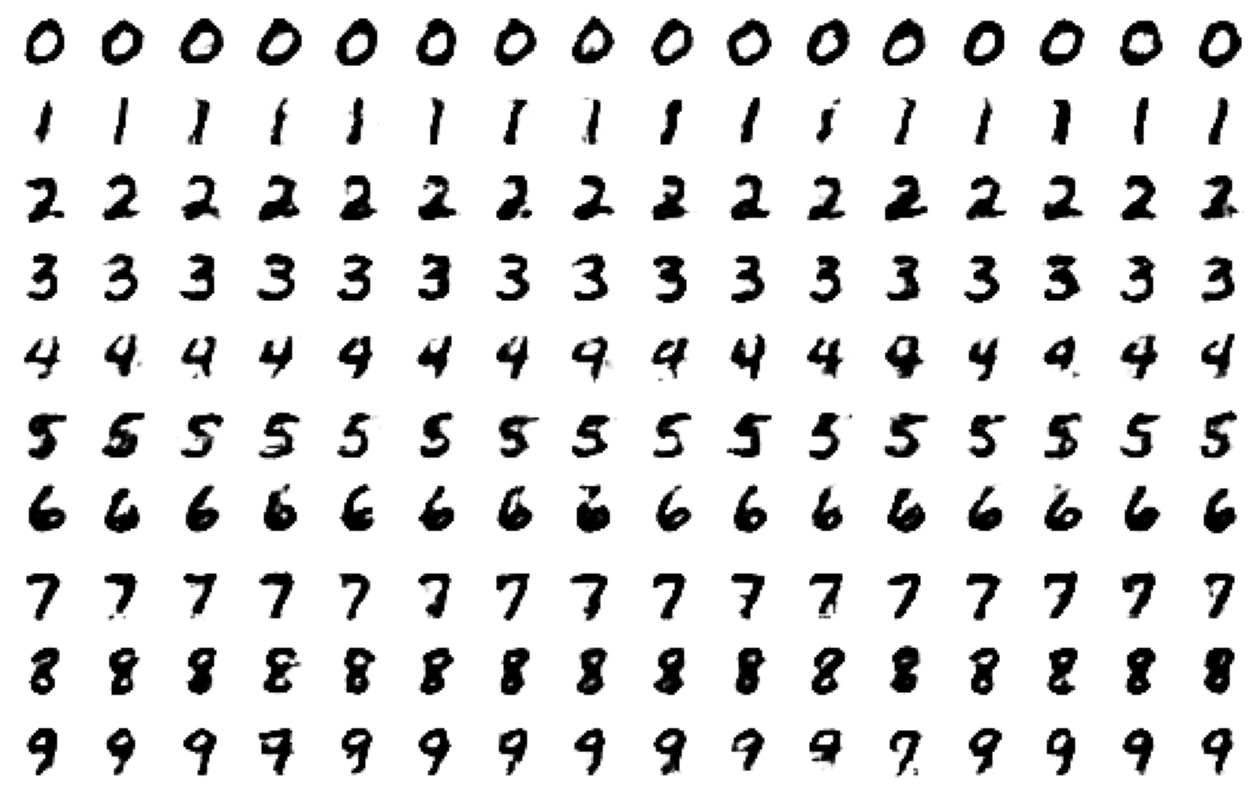

In [188]:
fig, axs = plt.subplots(ncols=16, nrows=10, figsize=(16, 10))
for i in range(10):
    for j in range(16):
        axs[i, j].imshow(generated_data_by_label[i][j, 0].cpu().detach(), cmap='gray_r')
        axs[i, j].set_axis_off()